# Capstone Project: Plant Seedlings Classification

In this notebook, an algorithm is created to differentiate between a crop seedling and a weed and design an automated weeding system.

### Step 1: Data Exploration

This step involves importing required libraries and data, viewing a sample of the data, getting the number of images in the data, getting a class wise count of the images in the data.

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import cv2
import matplotlib.pyplot as plt
import random
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm
import time
%matplotlib inline


from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns

from keras.utils import np_utils
from keras.preprocessing import image
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adagrad, Adadelta, RMSprop, Adam


Found 12 species of plant seedlings



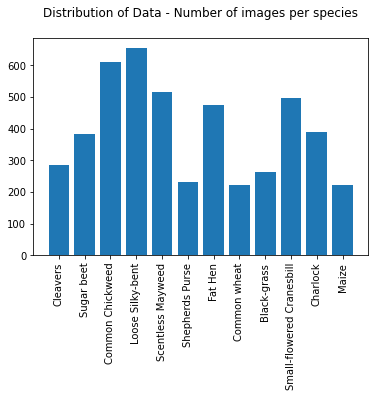

In [2]:
import matplotlib.pyplot as plt
import os


os.chdir("/Users/lakshmisrinivasan/Documents/ML/ML Advanced Project/Crop Seedling Classifier/")

train_dir = "Images/train"

species = [s for s in os.listdir(train_dir)
             if os.path.isdir(os.path.join(train_dir, s))]

print("Found {} species of plant seedlings\n".format(len(species)))

# Get the number of images per species

ips = {} #number of images in each species

for s in species:
    label_dir = os.path.join(train_dir, s)
    images=[os.path.join(label_dir, i) for i in os.listdir(label_dir) ]#if i.endswith(".jpg")]
    ips[s] = len(images)
    #print("{}: {} images".format(s, len(images)))
    

plt.bar(range(len(ips)), list(ips.values()), align='center')
plt.xticks(range(len(ips)), list(ips.keys()), rotation='vertical')
plt.title('Distribution of Data - Number of images per species\n')

plt.show()


['Cleavers', 'Sugar beet', 'Common Chickweed', 'Loose Silky-bent', 'Scentless Mayweed', 'Shepherds Purse', 'Fat Hen', 'Common wheat', 'Black-grass', 'Small-flowered Cranesbill', 'Charlock', 'Maize']


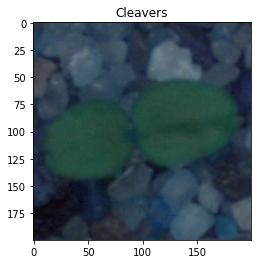

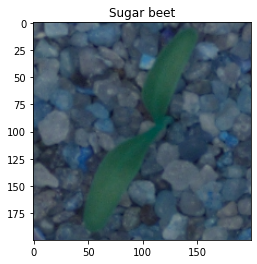

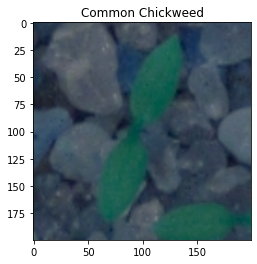

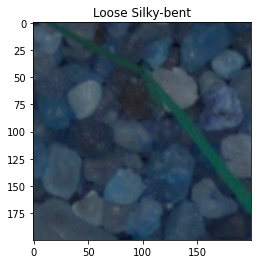

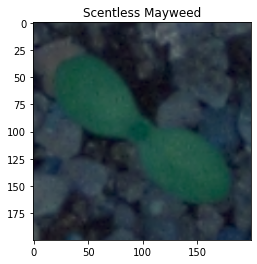

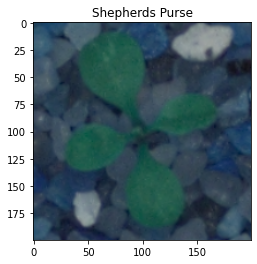

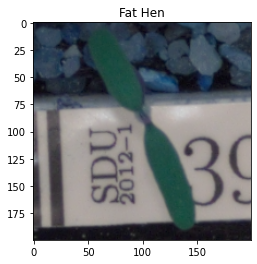

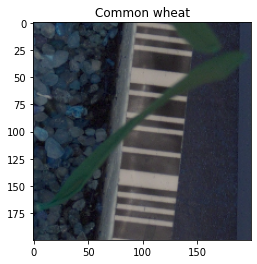

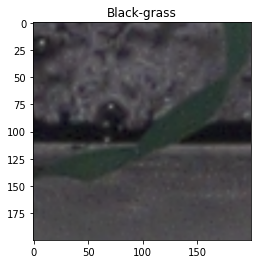

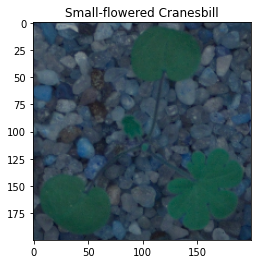

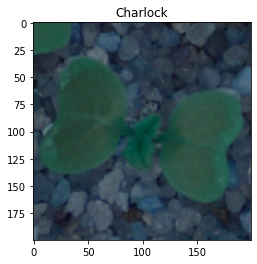

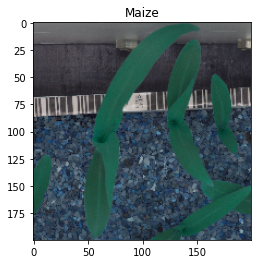

In [7]:
# Viewing sample images of the data
from PIL import Image
from PIL import ImageFilter
import random
import matplotlib.image as mpimg
import cv2

path = "Images/train/"
print(os.listdir(path))
#os.remove(path+".DS_Store") #Removes .DS_Store files in Mac

# Displays a random sample image from each species
img_array = []

for d in os.listdir(path):
    d_d = os.path.join(path, d)
    random_filename = random.choice([
        x for x in os.listdir(d_d)
        if os.path.isfile(os.path.join(d_d, x))
        ])
    file = d_d + '/' +random_filename
    #print(file)
    #Image.open(file).show()
    sample_img = cv2.imread(file)
    sample_resize = cv2.resize(sample_img, (200, 200))
    img_array.append(sample_resize)
    plt.figure()
    plt.title(d)
    plt.imshow(img_array[-1])
    
    




In [9]:
def load_dataset(path):
    data=load_files(path)
    plant_files=np.array(data['filenames'])
    plant_targets=np_utils.to_categorical(np.array(data['target']),12)
    return plant_files,plant_targets

train_files, train_targets = load_dataset('Images/train')
print('There are a total of %d plant images.' % len(train_files))

There are a total of 4750 plant images.


In [10]:
from collections import defaultdict
#creating dict with all categories as key, and their sample images as values

def create_dict(train_files, species):
    category_dict = defaultdict(list)
    for s in species:
        for i in range(len(train_files)):
            if s in train_files[i]:
                category_dict[s].append(train_files[i])
    return category_dict
category_dict = create_dict(train_files, species)

### Splitting Training, Validation and Testing Data

In [11]:
from sklearn.model_selection import train_test_split

x_train_val, x_test, y_train_val, y_test = train_test_split(train_files, train_targets, test_size = 0.15, random_state=32)
print('No of images in training-validation set: ', len(x_train_val))
print('No of images in test set: ', len(x_test))
print('--------------------------------')
print('')
print('Splitting train and validation set: ')
x_train, x_val, train_targets, val_targets = train_test_split(x_train_val, y_train_val, test_size = 0.2, random_state=32)
print('No of images in training set: ', len(x_train))
print('No of images in validation set: ', len(x_val))
print('--------------------------------')
print('')
print('Categorical distribution of training set after train-val split: ')
train_dict = create_dict(x_train, species)
for key in train_dict:
    print(key," : ", len(train_dict[key]))

No of images in training-validation set:  4037
No of images in test set:  713
--------------------------------

Splitting train and validation set: 
No of images in training set:  3229
No of images in validation set:  808
--------------------------------

Categorical distribution of training set after train-val split: 
Cleavers  :  195
Sugar beet  :  275
Common Chickweed  :  408
Loose Silky-bent  :  438
Scentless Mayweed  :  347
Shepherds Purse  :  157
Fat Hen  :  321
Common wheat  :  144
Black-grass  :  170
Small-flowered Cranesbill  :  346
Charlock  :  270
Maize  :  158


In [12]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    ''' 
    loads RGB image as PIL.Image.Image type
    converts PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    converts 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    '''
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

train_tensors = paths_to_tensor(x_train).astype('float32')/255
val_tensors = paths_to_tensor(x_val).astype('float32')/255
test_tensors = paths_to_tensor(x_test).astype('float32')/255

100%|████████████████████████████████████████| 713/713 [00:05<00:00, 124.22it/s]


In [13]:
train_tensors.shape


(3229, 224, 224, 3)

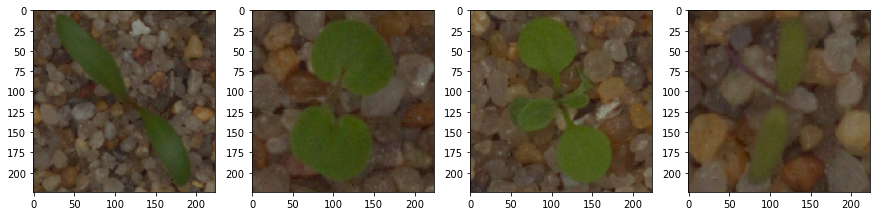

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(15,15))

axs[0].imshow(train_tensors[23])
axs[1].imshow(train_tensors[40])
axs[2].imshow(train_tensors[42])
axs[3].imshow(train_tensors[76])

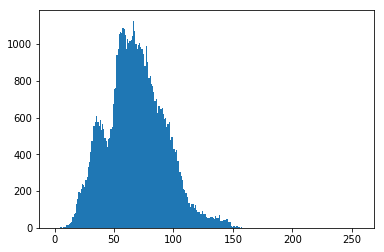

In [11]:
# Viewing histograms of pictures to determine brightness of pictures 
img = cv2.imread('Images/Cleavers/005b4a3e3.jpg')
plt.hist(img.ravel(),256,[0,256]); plt.show()

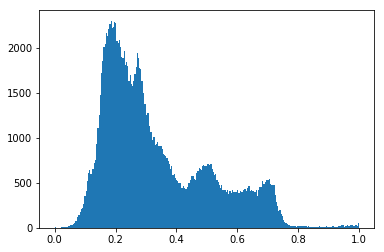

In [12]:
plt.hist(train_tensors[0].ravel(),256,[0,1])
plt.show()

#### In the above plots, it can be seen that the histogram is slightly skewed to the left, indicating darker pictures.

In [20]:
# Following has been adapted from - https://github.com/GeekLiB/keras/blob/master/keras/metrics.py
from keras import backend as K
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1score(y_true, y_pred, beta =1):
    '''Calculates the f-measure (f1 score), the harmonic mean of precision and recall.
        This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    '''
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0.0 # Returning float type to maintain same return data type

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    f1score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return f1score

In [21]:
model= Sequential()

model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', activation ='relu',input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(GlobalAveragePooling2D())

model.add(Dense(12,activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      1216      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 112, 112, 16)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      12832     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 56, 56, 32)       

In [22]:
#optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = 'adadelta', loss = "categorical_crossentropy", metrics = ["accuracy", f1score])

In [24]:
checkpointer = ModelCheckpoint(filepath='saved_models/psc_no_aug.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit(train_tensors, train_targets, epochs = 5, 
                    validation_data = (val_tensors,val_targets),
                    callbacks=[checkpointer],batch_size = 100)

Epoch 1/5
33/33 [==============================] - ETA: 0s - loss: 2.4710 - accuracy: 0.1356 - f1score: 0.0000e+00
Epoch 00001: val_loss improved from inf to 2.46759, saving model to saved_models/psc_no_aug.hdf5
33/33 [==============================] - 11s 308ms/step - loss: 2.4710 - accuracy: 0.1356 - f1score: 0.0000e+00 - val_loss: 2.4676 - val_accuracy: 0.1399 - val_f1score: 0.0000e+00
Epoch 2/5
33/33 [==============================] - ETA: 0s - loss: 2.4704 - accuracy: 0.1356 - f1score: 0.0000e+00
Epoch 00002: val_loss improved from 2.46759 to 2.46724, saving model to saved_models/psc_no_aug.hdf5
33/33 [==============================] - 10s 292ms/step - loss: 2.4704 - accuracy: 0.1356 - f1score: 0.0000e+00 - val_loss: 2.4672 - val_accuracy: 0.1399 - val_f1score: 0.0000e+00
Epoch 3/5
33/33 [==============================] - ETA: 0s - loss: 2.4698 - accuracy: 0.1356 - f1score: 0.0000e+00
Epoch 00003: val_loss improved from 2.46724 to 2.46690, saving model to saved_models/psc_no_aug.h

In [25]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
'''
    Function to evaluate the performance of the model and confusion matrix
    returns Performance Metric - f1 score
    And confusion matrix
'''
def evaluate_model(model, weights_path, train_tensors, test_tensors):
    model.load_weights(weights_path)
    y_pred = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in train_tensors]
    y_true = np.argmax(test_tensors, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    performance = f1_score(y_true, y_pred, average ='micro')
    return performance, cm

benchmark_performance = evaluate_model(model, 'saved_models/psc_no_aug.hdf5', test_tensors, y_test)
print('Performance evaluated by f1 score for the benchmark model is: ', benchmark_performance[0])

2022-02-28 11:07:02.272901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Performance evaluated by f1 score for the benchmark model is:  0.14446002805049088


In [26]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train_tensors)
print(len(train_tensors))

3229


In [28]:
# Referred from https://github.com/DeepLearningSandbox/DeepLearningSandbox/blob/master/transfer_learning/fine-tune.py
from keras import applications
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model

base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224,224,3))
# freezing the first 100 layers
for layer in base_model.layers[:100]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)

predictions = Dense(12, activation = 'softmax')(x)
model_inception = Model(base_model.input, predictions)
model_inception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_100 (Conv2D)            (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_100[0][0]']             
 ormalization)                  )                                                             

In [29]:
model_inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy", f1score])

In [30]:
batch = 50

checkpointer = ModelCheckpoint(filepath='saved_models/inception_with_online_aug_af.hdf5', 
                               verbose=1, save_best_only=True)

history = model_inception.fit_generator(datagen.flow(train_tensors,train_targets,batch_size=batch),epochs = 15, 
                                       validation_data = (val_tensors,val_targets),
                              verbose = 1, steps_per_epoch=train_tensors.shape[0] // batch
                              , callbacks=[ checkpointer])

/var/folders/dl/zbb4bx4d437d3kwwx_r7frpw0000gn/T/ipykernel_849/2038589807.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_inception.fit_generator(datagen.flow(train_tensors,train_targets,batch_size=batch),epochs = 15,


Epoch 1/15


2022-02-28 11:12:11.699655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - ETA: 0s - loss: 0.7550 - accuracy: 0.7521 - f1score: 0.7403

2022-02-28 11:12:44.642192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 13.50817, saving model to saved_models/inception_with_online_aug_af.hdf5
64/64 [==============================] - 40s 485ms/step - loss: 0.7550 - accuracy: 0.7521 - f1score: 0.7403 - val_loss: 13.5082 - val_accuracy: 0.1027 - val_f1score: 0.0970
Epoch 2/15
64/64 [==============================] - ETA: 0s - loss: 0.3209 - accuracy: 0.8805 - f1score: 0.8842
Epoch 00002: val_loss improved from 13.50817 to 2.75472, saving model to saved_models/inception_with_online_aug_af.hdf5
64/64 [==============================] - 28s 428ms/step - loss: 0.3209 - accuracy: 0.8805 - f1score: 0.8842 - val_loss: 2.7547 - val_accuracy: 0.5124 - val_f1score: 0.5092
Epoch 3/15
64/64 [==============================] - ETA: 0s - loss: 0.2769 - accuracy: 0.9075 - f1score: 0.9068
Epoch 00003: val_loss improved from 2.75472 to 1.99111, saving model to saved_models/inception_with_online_aug_af.hdf5
64/64 [==============================] - 27s 418ms/step - loss: 0.2769 - ac

In [31]:
model_inception.load_weights('saved_models/inception_with_online_aug_af.hdf5')
incept_performance, cm = evaluate_model(model_inception, 'saved_models/inception_with_online_aug_af.hdf5', 
                                       test_tensors,y_test)


2022-02-28 11:19:25.964291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [95]:
print("F1 Score for the model using transfer learning is: ", incept_performance)

F1 Score for the model using transfer learning is:  0.8653576437587658


In [96]:

incept_performance_val, cm_val = evaluate_model(model_inception, 'saved_models/inception_with_online_aug_af.hdf5', 
                                       val_tensors,val_targets)
print("F1 Score for the model using transfer learning is: ", incept_performance_val)

F1 Score for the model using transfer learning is:  0.8824257425742574


dict_keys(['loss', 'accuracy', 'f1score', 'val_loss', 'val_accuracy', 'val_f1score'])


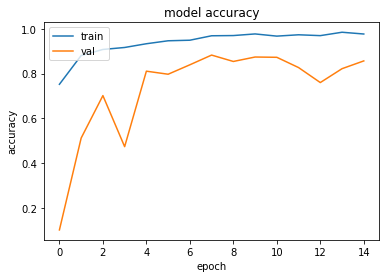

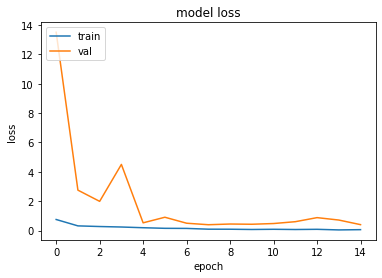

In [34]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [67]:
from keras.applications.xception import Xception
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
base_model_xception = Xception(include_top=False, weights='imagenet', input_shape=(224,224,3))
count =0
for layer in base_model_xception.layers[:75]:
    layer.trainable = False
y = base_model_xception.layers[-50].output
y = GlobalAveragePooling2D()(y)
y = Dense(256, activation= 'tanh')(y)
y = Dropout(0.3)(y)
y = Dense(256, activation = 'tanh')(y)
y = Dropout(0.2)(y)
y = Dense(64, activation = 'tanh')(y)
y = Dropout(0.2)(y)
predictions = Dense(12, activation = 'softmax')(y)
model_xception = Model(base_model_xception.input, predictions)
model_xception.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [68]:
model_xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy", f1score])

In [69]:
batch = 50

checkpointer = ModelCheckpoint(filepath='saved_models/xception_without_aug_af.hdf5', 
                               verbose=1, save_best_only=True)

history = model_xception.fit_generator(datagen.flow(train_tensors,train_targets,batch_size=batch),epochs = 15, 
                                       validation_data = (val_tensors,val_targets),
                              verbose = 1, steps_per_epoch=train_tensors.shape[0] // batch
                              , callbacks=[ checkpointer])

/var/folders/dl/zbb4bx4d437d3kwwx_r7frpw0000gn/T/ipykernel_849/2489899225.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_xception.fit_generator(datagen.flow(train_tensors,train_targets,batch_size=batch),epochs = 15,


Epoch 1/15


2022-02-28 18:30:01.448161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - ETA: 0s - loss: 1.3314 - accuracy: 0.5558 - f1score: 0.4477

2022-02-28 18:30:28.959491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.96678, saving model to saved_models/xception_without_aug_af.hdf5
64/64 [==============================] - 34s 486ms/step - loss: 1.3314 - accuracy: 0.5558 - f1score: 0.4477 - val_loss: 0.9668 - val_accuracy: 0.6572 - val_f1score: 0.6502
Epoch 2/15


/Users/lakshmisrinivasan/tensorflow-proj/tensenv/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


64/64 [==============================] - ETA: 0s - loss: 0.4312 - accuracy: 0.8616 - f1score: 0.8562
Epoch 00002: val_loss improved from 0.96678 to 0.68799, saving model to saved_models/xception_without_aug_af.hdf5
64/64 [==============================] - 30s 457ms/step - loss: 0.4312 - accuracy: 0.8616 - f1score: 0.8562 - val_loss: 0.6880 - val_accuracy: 0.7884 - val_f1score: 0.7910
Epoch 3/15
64/64 [==============================] - ETA: 0s - loss: 0.3026 - accuracy: 0.8975 - f1score: 0.8968
Epoch 00003: val_loss improved from 0.68799 to 0.57055, saving model to saved_models/xception_without_aug_af.hdf5
64/64 [==============================] - 29s 456ms/step - loss: 0.3026 - accuracy: 0.8975 - f1score: 0.8968 - val_loss: 0.5705 - val_accuracy: 0.8168 - val_f1score: 0.8207
Epoch 4/15
64/64 [==============================] - ETA: 0s - loss: 0.2215 - accuracy: 0.9302 - f1score: 0.9279
Epoch 00004: val_loss improved from 0.57055 to 0.25114, saving model to saved_models/xception_without_a

In [70]:
model_xception.load_weights('saved_models/xception_without_aug_af.hdf5')
xcept_performance, cm = evaluate_model(model_xception, 'saved_models/xception_without_aug_af.hdf5', 
                                       test_tensors,y_test)


2022-02-28 18:37:41.022991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [71]:

print("F1 Score for the model using transfer learning is: ", xcept_performance)

F1 Score for the model using transfer learning is:  0.9032258064516129


dict_keys(['loss', 'accuracy', 'f1score', 'val_loss', 'val_accuracy', 'val_f1score'])


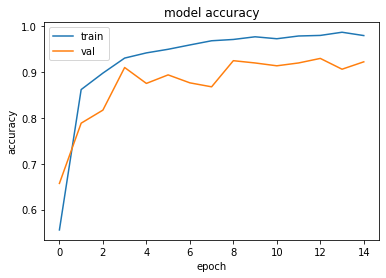

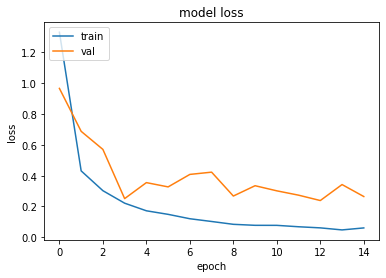

In [73]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Data Augmentation

Data augmentation has been performed offline so as to save time when running the program. With the help of data augmentation, a balanced dataset has now been obtained. This was done using the script ImgAugmentor.py. It was created after referring the work in https://github.com/tomahim/py-image-dataset-generator/blob/master/augmentation.py

Found 12 species of plant seedlings



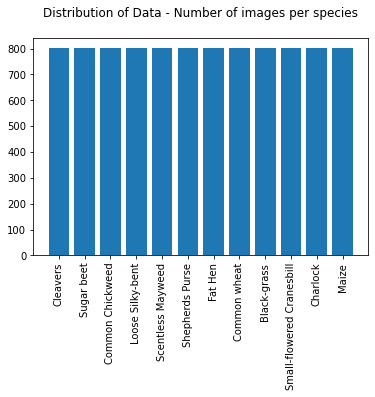

In [75]:
# After Data Augmentation

train_dir = "Images/JPG_Augmented"

species = [s for s in os.listdir(train_dir)
             if os.path.isdir(os.path.join(train_dir, s))]

print("Found {} species of plant seedlings\n".format(len(species)))

# Get the number of images per species

ips = {} #number of images in each species

for s in species:
    label_dir = os.path.join(train_dir, s)
    images=[os.path.join(label_dir, i) for i in os.listdir(label_dir) if i.endswith(".jpg")]
    ips[s] = len(images)
    #print("{}: {} images".format(s, len(images)))
    

plt.bar(range(len(ips)), list(ips.values()), align='center')
plt.xticks(range(len(ips)), list(ips.keys()), rotation='vertical')
plt.title('Distribution of Data - Number of images per species\n')

plt.show()

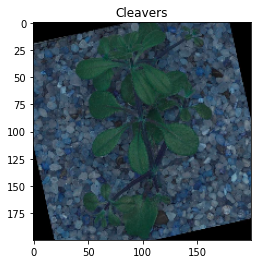

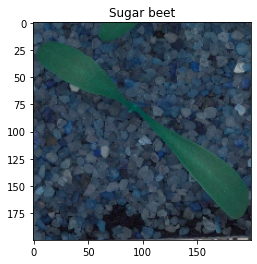

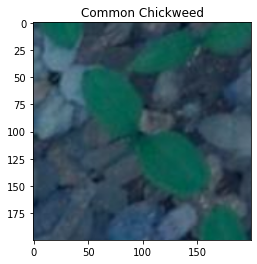

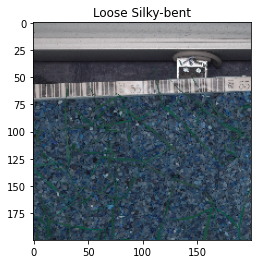

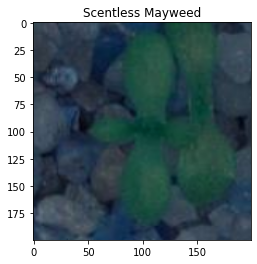

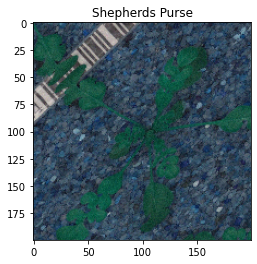

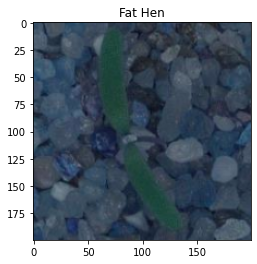

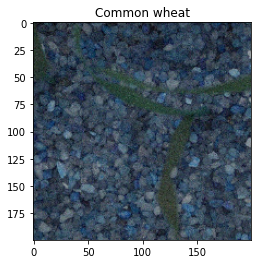

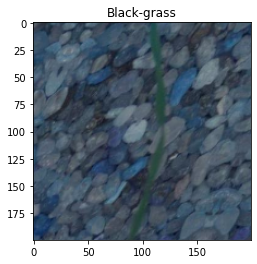

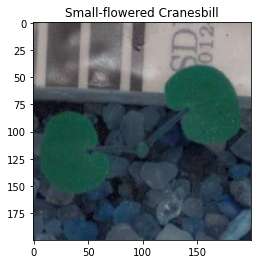

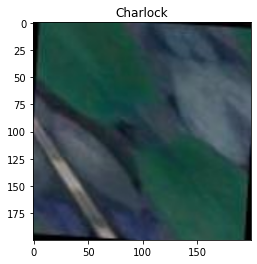

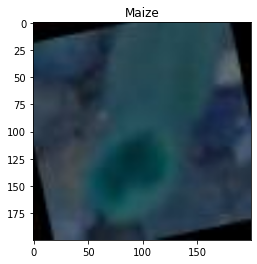

In [78]:
# Viewing sample images of the data
from PIL import Image
from PIL import ImageFilter
import random
import matplotlib.image as mpimg
import cv2

path = "Images/JPG_Augmented/"
#print(os.listdir(path))
#os.remove(path+".DS_Store") #Removes .DS_Store files in Mac

# Displays a random sample image from each species
img_array = []

for d in os.listdir(path):
    d_d = os.path.join(path, d)
    random_filename = random.choice([
        x for x in os.listdir(d_d)
        if os.path.isfile(os.path.join(d_d, x))
        ])
    file = d_d + '/' +random_filename
    #print(file)
    #Image.open(file).show()
    sample_img = cv2.imread(file)
    sample_resize = cv2.resize(sample_img, (200, 200))
    img_array.append(sample_resize)
    plt.figure()
    plt.title(d)
    plt.imshow(img_array[-1])
    
    




In [80]:

aug_train_files, aug_train_targets = load_dataset('Images/JPG_Augmented')
print('There are a total of %d plant images.' % len(aug_train_files))

There are a total of 9612 plant images.


In [81]:

category_dict = create_dict(aug_train_files, species)

### Splitting Training, Validation and Testing Data

In [82]:
from sklearn.model_selection import train_test_split

aug_x_train_val, aug_x_test, aug_y_train_val, aug_y_test = train_test_split(aug_train_files, aug_train_targets,
                                                                            test_size = 0.2, random_state=13)
print('No of images in training-validation set: ', len(aug_x_train_val))
print('No of images in test set: ', len(aug_x_test))
print('--------------------------------')
print('')
print('Splitting train and validation set: ')
aug_x_train, aug_x_val, aug_train_targets, aug_val_targets = train_test_split(aug_x_train_val, aug_y_train_val,
                                                                              test_size = 0.25, random_state=42)
print('No of images in training set: ', len(aug_x_train))
print('No of images in validation set: ', len(aug_x_val))
print('--------------------------------')
print('')
print('Categorical distribution of training set after train-val split: ')
train_dict = create_dict(aug_x_train, species)
for key in train_dict:
    print(key," : ", len(train_dict[key]))

No of images in training-validation set:  7689
No of images in test set:  1923
--------------------------------

Splitting train and validation set: 
No of images in training set:  5766
No of images in validation set:  1923
--------------------------------

Categorical distribution of training set after train-val split: 
Cleavers  :  485
Sugar beet  :  462
Common Chickweed  :  486
Loose Silky-bent  :  465
Scentless Mayweed  :  490
Shepherds Purse  :  472
Fat Hen  :  458
Common wheat  :  467
Black-grass  :  464
Small-flowered Cranesbill  :  491
Charlock  :  516
Maize  :  510


In [83]:


aug_train_tensors = paths_to_tensor(aug_x_train).astype('float32')/255
aug_val_tensors = paths_to_tensor(aug_x_val).astype('float32')/255
aug_test_tensors = paths_to_tensor(aug_x_test).astype('float32')/255

100%|██████████████████████████████████████| 1923/1923 [00:05<00:00, 347.95it/s]


In [84]:
aug_train_tensors.shape


(5766, 224, 224, 3)

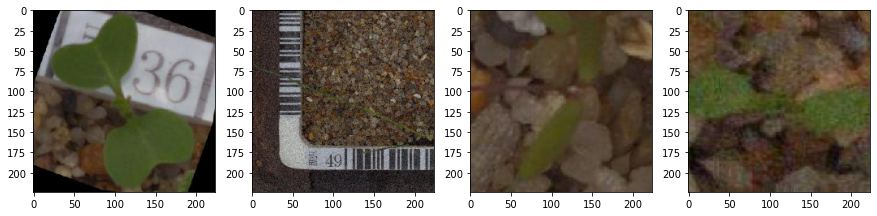

In [85]:
fig, axs = plt.subplots(1, 4, figsize=(15,15))

axs[0].imshow(aug_train_tensors[0])
axs[1].imshow(aug_train_tensors[13])
axs[2].imshow(aug_train_tensors[42])
axs[3].imshow(aug_train_tensors[175])

In [90]:
from keras.applications.xception import Xception
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
base_model_xception = Xception(include_top=False, weights='imagenet', input_shape=(224,224,3))
count =0
for layer in base_model_xception.layers[:75]:
    layer.trainable = False
y = base_model_xception.layers[-50].output
y = GlobalAveragePooling2D()(y)
y = Dense(256, activation= 'relu')(y)
y = Dropout(0.4)(y)
y = Dense(256, activation = 'relu')(y)
y = Dropout(0.5)(y)
y = Dense(64, activation = 'relu')(y)
y = Dropout(0.4)(y)
predictions = Dense(12, activation = 'softmax')(y)
model_xception = Model(base_model_xception.input, predictions)
model_xception.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [91]:
model_xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1score])

In [92]:
batch = 32

checkpointer = ModelCheckpoint(filepath='saved_models/xception_with_aug_af.hdf5', 
                               verbose=1, save_best_only=True)

history = model_xception.fit(aug_train_tensors,aug_train_targets,
                             validation_data = (aug_val_tensors,aug_val_targets),
                             epochs=6, batch_size=batch, 
                              verbose = 1, callbacks=[ checkpointer])

Epoch 1/6


2022-02-28 19:43:34.653492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


181/181 [==============================] - ETA: 0s - loss: 1.8296 - f1score: 0.2329

2022-02-28 19:44:19.513734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.06674, saving model to saved_models/xception_with_aug_af.hdf5
181/181 [==============================] - 60s 322ms/step - loss: 1.8296 - f1score: 0.2329 - val_loss: 1.0667 - val_f1score: 0.6389
Epoch 2/6


/Users/lakshmisrinivasan/tensorflow-proj/tensenv/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


181/181 [==============================] - ETA: 0s - loss: 0.6815 - f1score: 0.7569
Epoch 00002: val_loss improved from 1.06674 to 0.59976, saving model to saved_models/xception_with_aug_af.hdf5
181/181 [==============================] - 59s 327ms/step - loss: 0.6815 - f1score: 0.7569 - val_loss: 0.5998 - val_f1score: 0.7678
Epoch 3/6
181/181 [==============================] - ETA: 0s - loss: 0.4209 - f1score: 0.8536
Epoch 00003: val_loss improved from 0.59976 to 0.47976, saving model to saved_models/xception_with_aug_af.hdf5
181/181 [==============================] - 60s 331ms/step - loss: 0.4209 - f1score: 0.8536 - val_loss: 0.4798 - val_f1score: 0.8233
Epoch 4/6
181/181 [==============================] - ETA: 0s - loss: 0.2994 - f1score: 0.9002
Epoch 00004: val_loss improved from 0.47976 to 0.46284, saving model to saved_models/xception_with_aug_af.hdf5
181/181 [==============================] - 60s 333ms/step - loss: 0.2994 - f1score: 0.9002 - val_loss: 0.4628 - val_f1score: 0.8361

In [93]:
model_xception.load_weights('saved_models/xception_with_aug_af.hdf5')
xcept_performance, cm = evaluate_model(model_xception, 'saved_models/xception_with_aug_af.hdf5', 
                                       aug_test_tensors,aug_y_test)


2022-02-28 19:50:13.866882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [94]:

accuracy=model_xception.evaluate(x=aug_test_tensors,y=aug_y_test,batch_size=32)
print("Loss of the model: {} , Accuracy of Model :{} ".format(accuracy[0],accuracy[1]))
print("F1 Score for the model using transfer learning and data augmentation is: ", xcept_performance)

61/61 [==============================] - 14s 203ms/step - loss: 0.4589 - f1score: 0.8753
Loss of the model: 0.4588710367679596 , Accuracy of Model :0.8752958178520203 
F1 Score for the model using transfer learning and data augmentation is:  0.8720748829953198
